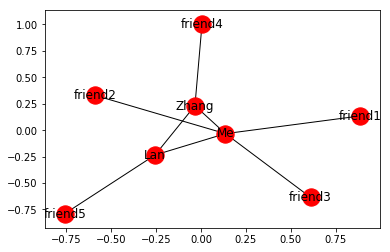

In [2]:
import networkx as nx
import gensim 
import numpy as np
import matplotlib.pyplot as plt
node_list=['friend1','friend2','friend3','Me','Zhang','Lan','friend4','friend5']
edge_list=[('friend1','Me',1),('friend2','Me',1),('friend3','Me',1),('Zhang','Me',5.20)
,('Lan','Me',2.50),('friend4','Zhang',1),('friend5','Lan',1),('Zhang','Lan',2.50)]
#创建空图
G=nx.Graph()
#从一个列表中添加节点
G.add_nodes_from(node_list)
#根据（边，边，权重）加载
G.add_weighted_edges_from(edge_list)
#plot
nx.draw_networkx(G,node_list=G.nodes(),edges=G.edges())

In [56]:
#通过alias sample创建alias table
import numpy as np
def create_alias_table(area_ratio):
    '''
    area_ratio[i]代表
    '''
    N=len(area_ratio)
    accept,alias=[0]*N,[0]*N
    small,large=[],[]
    area_ratio=np.array(area_ratio)*N
    for i,prob in enumerate(area_ratio):
        if prob<1:
            small.append(i)
        else:
            large.append(i)
    while large and small:
        small_idx,large_idx=small.pop(),large.pop()
        accept[small_idx]=area_ratio[small_idx]
        alias[small_idx]=large_idx
        area_ratio[large_idx]=area_ratio[large_idx]-(1-alias[small_idx])
        if area_ratio[large_idx]<1:
            small.append(large_idx)
        else:
            large.append(large_idx)
            
    while large:
        large_idx=large.pop()
        accept[large_idx]=1
    while small:
        small_idx=small.pop()
        accept[small_idx]=1
    
    return accept,alias
        

In [67]:
def alias_sample(accept,alias):
    N=len(accept)
    i=int(np.floor(np.random.rand()*N))
    r=np.random.rand()
    if r<accept[i]:
        return i
    else:
        return alias[i]

In [68]:
G.get_edge_data('Me','Zhang')['weight']
list(G.nodes())
list(G.edges())
G.has_edge('Zhang','Me')
sorted(G.neighbors('Me'))


['Lan', 'Zhang', 'friend1', 'friend2', 'friend3']

In [85]:
def get_alias_edge(G,t,v,p,q):
    '''t:previous node v:current node'''
    unnormalized_probs=[]
    for x in sorted(G.neighbors(v)):
        weight=G.get_edge_data(x,v)['weight']
        if x==t:  #回走
            unnormalized_probs.append(weight/p)
        elif G.has_edge(x,t): #BFS
            unnormalized_probs.append(weight)
        else: #DFS
            unnormalized_probs.append(weight/q)
    norm=sum(unnormalized_probs)
    normalized_probs=list(map(lambda x:x/norm,unnormalized_probs))
    return create_alias_table(normalized_probs)
    

In [135]:
def preprocess_transition_probs(G,p,q):
    alias_nodes={}
    for node in sorted(G.nodes()):
        unnormalized_probs=[G.get_edge_data(node,nbr)['weight'] for nbr in sorted(G.neighbors(node))]
        norm=sum(unnormalized_probs)
        normalized_probs=list(map(lambda x:x/norm,unnormalized_probs))
        alias_nodes[node]=create_alias_table(normalized_probs)
    alias_edges={}
    for edge in list(G.edges()):
        alias_edges[edge]=get_alias_edge(G,edge[0],edge[1],p,q)
        alias_edges[(edge[1],edge[0])]=get_alias_edge(G,edge[1],edge[0],p,q)
    return alias_nodes,alias_edges
        

In [136]:
alias_nodes,alias_edges=preprocess_transition_probs(G,2,0.8)
alias_nodes

{'Lan': ([1, 1, 0.5], [0, 0, 1]),
 'Me': ([1, 1, 0.4672897196261683, 0.4672897196261683, 0.4672897196261683],
  [0, 0, 1, 1, 1]),
 'Zhang': ([0.8620689655172415, 1, 0.3448275862068966], [1, 0, 1]),
 'friend1': ([1], [0]),
 'friend2': ([1], [0]),
 'friend3': ([1], [0]),
 'friend4': ([1], [0]),
 'friend5': ([1], [0])}

In [137]:
alias_edges

{('friend1',
  'Me'): ([1,
   1,
   0.19801980198019803,
   0.49504950495049505,
   0.49504950495049505], [0, 0, 1, 1, 1]),
 ('Me', 'friend1'): ([1], [0]),
 ('friend2',
  'Me'): ([1,
   1,
   0.49504950495049505,
   0.19801980198019803,
   0.49504950495049505], [0, 0, 1, 1, 1]),
 ('Me', 'friend2'): ([1], [0]),
 ('friend3',
  'Me'): ([1,
   1,
   0.49504950495049505,
   0.49504950495049505,
   0.19801980198019803], [0, 0, 1, 1, 1]),
 ('Me', 'friend3'): ([1], [0]),
 ('Me', 'Zhang'): ([1, 1, 0.5905511811023623], [0, 0, 1]),
 ('Zhang',
  'Me'): ([1,
   1,
   0.7062146892655368,
   0.7062146892655368,
   0.7062146892655368], [0, 0, 1, 1, 1]),
 ('Me', 'Lan'): ([0.75, 1, 0.75], [1, 0, 1]),
 ('Lan',
  'Me'): ([0.6127450980392157,
   1,
   0.6127450980392157,
   0.6127450980392157,
   0.6127450980392157], [1, 0, 1, 1, 1]),
 ('Zhang', 'friend4'): ([1], [0]),
 ('friend4', 'Zhang'): ([0.9259259259259258, 1, 0.14814814814814814],
  [1, 0, 1]),
 ('Zhang', 'Lan'): ([1, 1, 0.75], [0, 0, 0]),
 ('Lan', 

In [138]:
def node2vec_walk(G,walk_length,start_node,alias_nodes,alias_edges):
    walk=[start_node]
    while len(walk)<walk_length:
        cur=walk[-1]
        cur_nbrs=sorted(G.neighbors(cur))
        if len(cur_nbrs)>0:
            if len(walk)==1:
                walk.append(cur_nbrs[alias_sample(alias_nodes[cur][0],alias_nodes[cur][1])])
            else:
                prev=walk[-2]
                next=cur_nbrs[alias_sample(alias_edges[(prev,cur)][0],alias_edges[(prev,cur)][1])]
                walk.append(next)
        else:
            break
    return walk

In [139]:
node2vec_walk(G,10,'Me',alias_nodes,alias_edges)

['Me', 'Zhang', 'Me', 'Lan', 'Zhang', 'Me', 'friend3', 'Me', 'friend3', 'Me']

In [140]:
import random
def simulate_walks(G,num_walks,walk_length,alias_nodes,alias_edges,rand=random.Random()):
    walks=[]
    nodes=list(G.nodes())
    for i in range(num_walks):
        rand.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(G,walk_length,node,alias_nodes,alias_edges))
    return walks
    

In [146]:
walks=simulate_walks(G,10,10,alias_nodes,alias_edges,rand=random.Random())

In [151]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=20, window=2, min_count=0, sg=1,iter=20)
model.wv['Zhang']

array([-0.13974336, -0.00535731, -0.07112405, -0.12068465, -0.04678886,
       -0.04699158,  0.13902713, -0.13237877, -0.20016567,  0.14598444,
       -0.03026583,  0.04862763,  0.03326393, -0.0760393 , -0.00311179,
        0.06341337,  0.02879526, -0.01971069,  0.03543255, -0.05967962],
      dtype=float32)

In [152]:
model.wv.most_similar('Zhang',topn=1)

[('Me', 0.9778188467025757)]